In [1]:
%load_ext autoreload
%autoreload 2

import fine_tune.train

/home/andrewhealey/autodistill-seggpt/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Segment Anything custom imported


In [2]:
cfg = None
dataset = None

In [3]:
import os
# set DATASET_DIRECTORY env var to "datasets/"
os.environ["DATASET_DIRECTORY"] = "datasets"

from fine_tune.configs.climbing import *

assert cfg is not None,"Must set config"
assert dataset is not None,"Must set training dataset"

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to datasets/Climbing-6 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 2985.98it/s]


In [4]:
import torch
seed = 5
torch.manual_seed(seed)
import numpy as np
np.random.seed(seed)
import random
random.seed(seed)

In [5]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
from fine_tune.load_datasets import load_datasets

train_dataset,valid_dataset = load_datasets(cfg.data,dataset)

Selecting classes ['climbing-holds', 'floor', 'person']


In [7]:
from fine_tune.models import WrappedSamModel

sam = WrappedSamModel(cfg).to(device)

encoder = sam.encoder
decoder = sam.decoder
predictor = sam.predictor

{}
warm started


In [8]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: andrewhealey (roboflow2). Use `wandb login --relogin` to force relogin


True

In [9]:
import torch

run_num = None

if run_num is not None:
    sam.load_state_dict(torch.load(f"runs/{run_num}/trainable.pt"))

In [10]:
from fine_tune.load_datasets import prepare_torch_dataset

print(cfg.data.points_per_mask)

curr_dataset = prepare_torch_dataset(predictor,cfg,train_dataset,max_prompts=cfg.data.train_prompts)
valid_curr_dataset = prepare_torch_dataset(predictor,cfg,valid_dataset,max_prompts=cfg.data.valid_prompts)

[1, 20, 20]


  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 81840.08it/s]


In [11]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import threshold, normalize

import cv2
import numpy as np

from numpy.random import permutation
from tqdm import tqdm
import json

from fine_tune.common import SamDataset,get_max_iou_masks,to
from fine_tune.viz import mask_to_img,clip_together_imgs, show_confusion_matrix, render_prompt


In [12]:
from PIL import Image
import numpy as np

def evaluate():
    pred_classes = []
    gt_classes = []

    running_loss = 0.0
    running_count = 0

    running_cls_loss = 0.0
    running_cls_count = 0
    
    sam.eval()

    for batch in tqdm(valid_curr_dataset):

        batch = to(batch,device)
        prompt_input, gt_info, gt_cls_info, imgs,sizes, prompt = batch

        use_cls = cfg.model.decoder.use_cls and gt_cls_info is not None

        with torch.no_grad():
            encoder_output = encoder.get_decoder_input(imgs,prompt)

            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)

            _,losses = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)

            normal_loss = losses["loss"]
            running_loss += normal_loss.item()
            running_count += 1

            cls_loss = losses["cls_loss"]
            running_cls_loss += cls_loss.item()
            running_cls_count += 1

            if use_cls:
                # get pred gt class
                (cls_upscaled_masks,cls_binary_masks), pred_cls = decoder.postprocess(cls_low_res_masks,cls_iou_predictions,sizes)

                _,_,_,best_cls,_ = get_max_iou_masks(gt_info["masks"],cls_binary_masks,gt_cls_info["gt_cls"],torch.arange(cfg.data.num_classes).to(device))

                pred_classes.append(pred_cls)
                gt_classes.append(best_cls)

    valid_loss = running_loss/running_count
    valid_cls_loss = running_cls_loss/running_cls_count

    print(f"VALID - Base loss: {valid_loss:.4f} - Class loss: {valid_cls_loss:.4f}")

    wandb.log({
        "valid_normal_loss": valid_loss,
        "valid_cls_loss": valid_cls_loss,
    })

    if len(gt_classes) > 0:
        # calculate confusion matrix
        show_confusion_matrix(gt_classes, pred_classes, class_names=valid_dataset.classes)


In [13]:
from fine_tune.optimizer import get_optimizer

optimizer,scheduler = get_optimizer(cfg,sam)

Total trainable parameters: 552803


100%|██████████| 200/200 [00:15<00:00, 12.54it/s]


VALID - Base loss: 0.4479 - Class loss: 1.5292


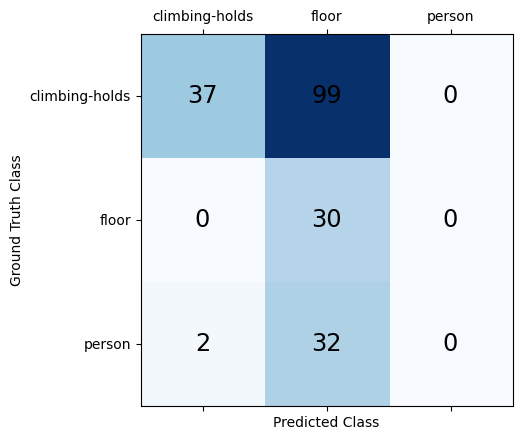

  0%|          | 4/7205 [00:00<07:37, 15.75it/s]

Loss: 1.2105023860931396


  3%|▎         | 202/7205 [00:15<09:04, 12.86it/s]

Loss: 1.4695081025362016


  6%|▌         | 402/7205 [00:30<09:46, 11.60it/s]

Loss: 0.98685970030725


  8%|▊         | 604/7205 [00:46<07:21, 14.94it/s]

Loss: 0.9523103924840689


 11%|█         | 803/7205 [01:02<07:37, 14.01it/s]

Loss: 0.760587221160531


 14%|█▍        | 1004/7205 [01:17<06:46, 15.27it/s]

Loss: 0.6784604353085161


 17%|█▋        | 1204/7205 [01:30<04:35, 21.80it/s]

Loss: 0.733083042614162


 19%|█▉        | 1403/7205 [01:42<06:08, 15.75it/s]

Loss: 0.6030780902504921


 22%|██▏       | 1602/7205 [01:58<09:27,  9.87it/s]

Loss: 0.6109292151778937


 25%|██▌       | 1803/7205 [02:09<04:23, 20.53it/s]

Loss: 0.5057327552139759


 28%|██▊       | 2004/7205 [02:19<04:05, 21.16it/s]

Loss: 0.5378251801803708


 31%|███       | 2202/7205 [02:29<04:17, 19.42it/s]

Loss: 0.6489257685467601


 33%|███▎      | 2403/7205 [02:39<04:07, 19.40it/s]

Loss: 0.5785300108231604


 36%|███▌      | 2603/7205 [02:49<03:41, 20.77it/s]

Loss: 0.5795753864757717


 39%|███▉      | 2802/7205 [02:59<04:34, 16.04it/s]

Loss: 0.41838839747011664


 42%|████▏     | 3004/7205 [03:09<03:21, 20.83it/s]

Loss: 0.616095795147121


 44%|████▎     | 3151/7205 [03:19<04:49, 13.99it/s]

In [14]:
from dataclasses import asdict

run = wandb.init(
    project="sam-fine-tune",
    config=asdict(cfg)
)

curr_iters = 0
accumulated_loss = 0

# track running avg of loss
recent_losses = []

curr_epoch = 0

# iter through dataset in random order
while curr_iters < cfg.train.max_steps:
    evaluate()
    sam.train()
    for i,idx in enumerate(tqdm(permutation(len(curr_dataset)))):

        with torch.no_grad():
            prompt_input, gt_info,gt_cls_info, imgs,sizes, prompt = batch = to(curr_dataset[idx],device)
        
        use_cls_loss = gt_cls_info is not None and cfg.model.decoder.use_cls
        
        has_fresh_prompt = True
        refinements_remaining = cfg.train.num_refinement_steps

        while has_fresh_prompt:
            has_fresh_prompt = False

            encoder_output = encoder.get_decoder_input(imgs,prompt)
            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)


            #
            # WandB
            #
            
            loss,loss_dict = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)

            input_img_torch = imgs[2]
            image_embeddings= encoder_output["image_embeddings"]

            loss_dict = {k:v.item() for k,v in loss_dict.items()}
            wandb.log(loss_dict)

            #
            # Logging
            #

            recent_losses += [loss.item()]
            recent_losses = recent_losses[-cfg.train.log_period:]

            if curr_iters % cfg.train.eval_period == 0:
                evaluate()
                sam.train()

            if curr_iters % cfg.train.log_period == 0:
                print(f"Loss: {sum(recent_losses)/len(recent_losses)}")

            curr_iters += 1

            if not cfg.train.run_grad: continue

            accumulated_loss += loss
            if curr_iters % cfg.train.batch_size == 0:
                optimizer.zero_grad()
                accumulated_loss /= torch.tensor(cfg.train.batch_size,dtype=torch.float32)
                accumulated_loss.backward()
                optimizer.step()
                accumulated_loss = 0
            
            scheduler.step()

            #
            # Progressive refinement
            #

            if refinements_remaining > 0:

                raise NotImplementedError("Need to update this to use new training system")

                refinements_remaining -= 1

                has_fresh_prompt = True

    curr_epoch += 1

In [ ]:
sam.eval()
1

WrappedSamModel(
  (decoder): WrappedMaskDecoder(
    (mask_decoder): MaskDecoder(
      (transformer): TwoWayTransformer(
        (layers): ModuleList(
          (0-1): 2 x TwoWayAttentionBlock(
            (self_attn): Attention(
              (q_proj): Linear(in_features=256, out_features=256, bias=True)
              (k_proj): Linear(in_features=256, out_features=256, bias=True)
              (v_proj): Linear(in_features=256, out_features=256, bias=True)
              (out_proj): Linear(in_features=256, out_features=256, bias=True)
            )
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (cross_attn_token_to_image): Attention(
              (q_proj): Linear(in_features=256, out_features=128, bias=True)
              (k_proj): Linear(in_features=256, out_features=128, bias=True)
              (v_proj): Linear(in_features=256, out_features=128, bias=True)
              (out_proj): Linear(in_features=128, out_features=256, bias=True)
       

In [ ]:
from glob import glob
import os

runs_dir = "runs_new"
run_ids = [int(fname) for fname in os.listdir(runs_dir)]
highest_run = max(run_ids) if len(run_ids) > 0 else 0
run_num = highest_run + 1
export_dir = f"{runs_dir}/{run_num}"
!mkdir -p $export_dir
print(f"Run saved to {export_dir}")

from fine_tune.export import export

export(export_dir,cfg,sam,device)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:08<00:00, 23.10it/s]


VALID - Base loss: 0.3277 - Class loss: 0.5119


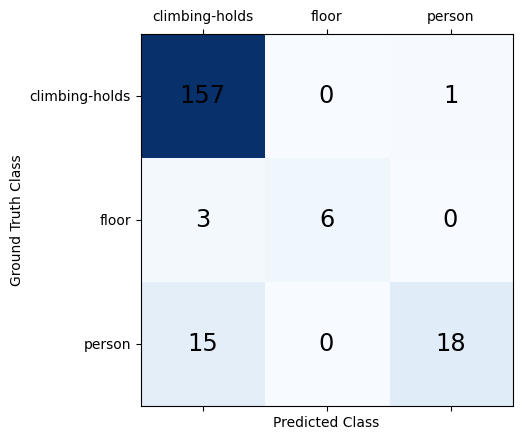

In [ ]:
evaluate()

Loss: 0.28022581338882446
Predicted IoU: 0.7143663763999939 real IoU: 0.15159668028354645


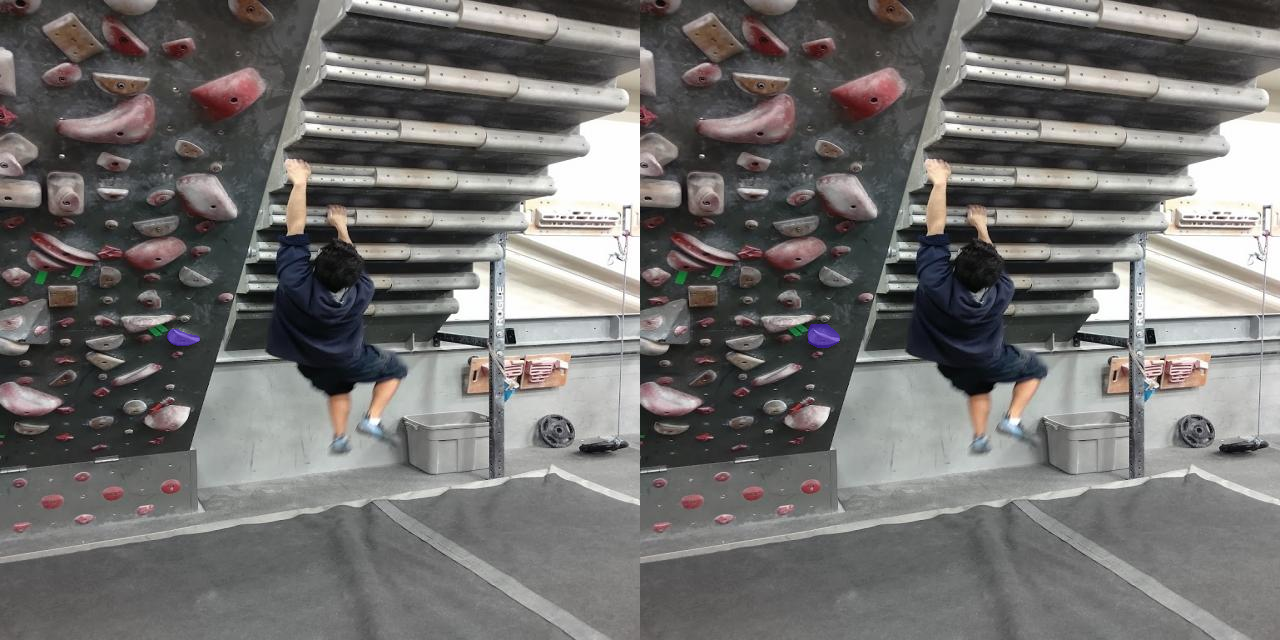

Cls loss: 0.3630715012550354
Predicted cls: 0 GT cls: 0
Predicted cls IoU: 0.7143663763999939 real cls IoU: 0.15159668028354645


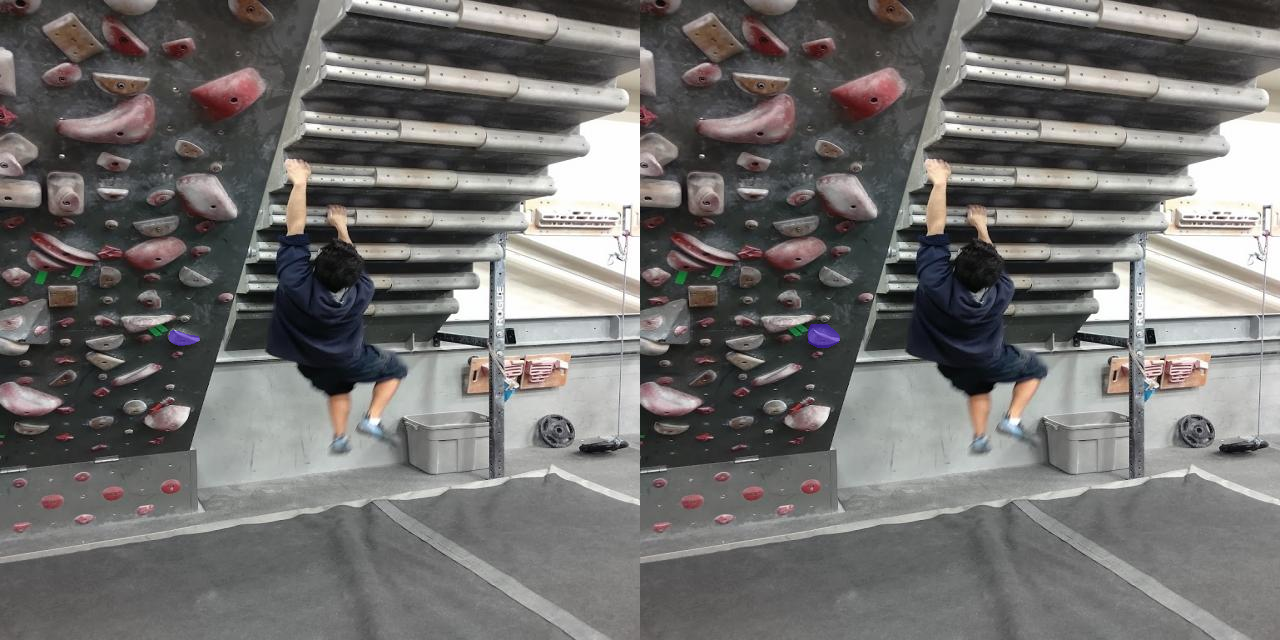

In [ ]:
from random import randint

v_c_ds = valid_curr_dataset
idx = randint(0,len(v_c_ds)-1)

prompt_input, gt_info,gt_cls_info, imgs,sizes, prompt = batch = to(v_c_ds[idx],device)

gt_masks = gt_info["masks"]
gt_cls = gt_cls_info["gt_cls"]

use_normal_tokens = True
use_cls_tokens = cfg.model.decoder.use_cls and gt_cls_info is not None

has_fresh_prompt = True
num_refinements_left = cfg.train.num_refinement_steps
while has_fresh_prompt:
    has_fresh_prompt = False

    with torch.no_grad():
        encoder_output = encoder.get_decoder_input(imgs,prompt)
        low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)

        loss,losses = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)
        
        (upscaled_masks,binary_masks),max_idx = decoder.postprocess(low_res_masks,iou_predictions,sizes)
        pred_iou = F.sigmoid(iou_predictions[0,max_idx]).item()
        binary_mask = binary_masks[max_idx]

        gt_binary_mask, _, _, _, _ = get_max_iou_masks(gt_masks,binary_mask[None,...])

        if use_cls_tokens:

            (cls_upscaled_masks,cls_binary_masks), pred_cls = decoder.postprocess(cls_low_res_masks,cls_iou_predictions,sizes)
            cls_binary_mask = cls_binary_masks[pred_cls,...]

            # get focal and dice loss between cls_binary_mask and closest gt mask
            cls_gt_binary_mask,_,max_iou,best_cls,_ = get_max_iou_masks(gt_masks,cls_binary_masks,gt_cls,torch.arange(cfg.data.num_classes).to(device))

        if num_refinements_left > 0:
            raise NotImplementedError("Need to update this to use new training system")

            has_fresh_prompt = True
            num_refinements_left -= 1

from PIL import Image

img = imgs[0]

if use_normal_tokens:
    print("Loss:",losses["loss"].item())
    print("Predicted IoU:",pred_iou,"real IoU:",max_iou.item())

    clip_together_imgs(mask_to_img(binary_mask,img),mask_to_img(gt_binary_mask,img)).show()

# print cls loss
if use_cls_tokens:
    print("Cls loss:",losses["cls_loss"].item())
    print("Predicted cls:",pred_cls.item(),"GT cls:",gt_cls.item())
    print("Predicted cls IoU:",pred_iou,"real cls IoU:",max_iou.item())

    clip_together_imgs(mask_to_img(cls_binary_mask,img),mask_to_img(gt_binary_mask,img)).show()

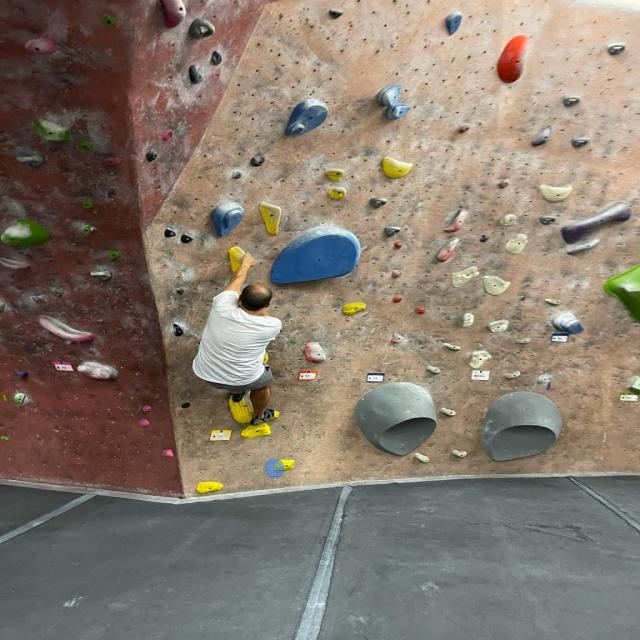

In [ ]:
from random import choice
import fine_tune.viz

name,prompt = choice(curr_dataset.prompts)
render_prompt(name,prompt,train_dataset)